# Install & Import Necessary Libraries

In [26]:
# Core Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification
)


In [3]:
# Connect  to drive to load dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Cleaned Data Set

In [5]:
# Load cleaned dataset to train model

amazon_electronics_df = pd.read_csv('/content/drive/MyDrive/Atikuzzaman/amazon_electronics_electronics_reviews_cleaned.csv')
sephora_skincare_df = pd.read_csv('/content/drive/MyDrive/Atikuzzaman/sephora_skincare_skincare_reviews_cleaned.csv')

In [6]:
# Show loaded dataset

amazon_electronics_df.head()

,Review,Rating,sentiment,review_length,polarity,label
0,well trying box towersthat sounded like music ...,5,positive,194,0.153092,2
1,ordered one wife one reading negative review p...,5,positive,140,0.220424,2
2,muy buen producto full juegos fhd hay problema...,5,positive,24,0.350000,2
3,sound quality unit phenomenal bose sounddock w...,5,positive,93,0.268527,2
4,good keeping cpu cool also downt forget downlo...,4,positive,24,0.525000,2


In [7]:
# Show loaded dataset

sephora_skincare_df.head()

,Review,Rating,sentiment,review_length,polarity,label
0,best eye serum ever used well worth money boug...,5,positive,81,0.036944,2
1,helped much stubborn texture purchase life,5,positive,12,0.312500,2
2,honestly not like product nothing seem make br...,2,negative,20,0.100000,0
3,okay started quarantine trying find skin routi...,5,positive,113,0.236111,2
4,good work wonder redness away almost immediate...,5,positive,16,0.562500,2


In [8]:
# Split amazon_electronics dataset into train (80%) and test (20%)

X_train, X_test, y_train, y_test = train_test_split(amazon_electronics_df['Review'],amazon_electronics_df['label'],train_size=0.80,random_state=50,stratify=amazon_electronics_df['label'])

print("Training set size:", len(X_train))
print("Validation set size:", len(X_test))


Training set size: 7992
Validation set size: 1999


In [9]:
# Prepare cross-domain test set (Sephora skincare reviews)

X_test_cross = sephora_skincare_df['Review']      # Text data for cross-domain testing
y_test_cross = sephora_skincare_df['label']       # Ground-truth sentiment labels

## Model 3 — DistilBERT Fine-Tuning

##  Load tokenizer

In [11]:
# Load the DistilBERT tokenizer (converts raw text into token IDs and attention masks)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the Amazon Electronics training set
# - truncation: cut longer texts to max_length
# - padding: pad shorter texts to uniform length
# - max_length: fixed sequence length used by DistilBERT

train_enc = tokenizer(
    list(X_train),
    truncation=True,
    padding=True,
    max_length=128
)

# Tokenize validation data (same preprocessing for consistency)

val_enc = tokenizer(
    list(X_test),
    truncation=True,
    padding=True,
    max_length=128
)

# Tokenize Sephora cross-domain test dataset

test_enc = tokenizer(
    list(X_test_cross),
    truncation=True,
    padding=True,
    max_length=128
)


## Create Torch Dataset

In [18]:
# Custom Dataset class for handling tokenized inputs and labels for DistilBERT
class SentimentDataset(Dataset):

    def __init__(self, encodings, labels):
        """
        Store tokenized encodings (input_ids, attention_mask)
        and corresponding sentiment labels.

        Parameters
        ----------
        encodings : dict
            Output from the DistilBERT tokenizer (input_ids, attention_mask).
        labels : list or array
            List of integer sentiment labels.
        """
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieve a single sample by index.
        Converts tokenized inputs and labels into PyTorch tensors.

        Returns
        -------
        dict
            A dictionary containing:
            - input_ids
            - attention_mask
            - labels
        """
        # Convert each tokenized item to a tensor for PyTorch
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

        # Add labels to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])

        return item


# Create dataset objects for training, validation, and cross-domain testing
train_dataset = SentimentDataset(train_enc, list(y_train))
val_dataset   = SentimentDataset(val_enc, list(y_test))
test_dataset  = SentimentDataset(test_enc, list(y_test_cross))


## Load DistilBERT Model

In [19]:
# Select computation device:
# - Use GPU (CUDA) if available for faster training
# - Otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load pre-trained DistilBERT model for sequence classification
# num_labels=3 → because your sentiment task has 3 classes (negative, neutral, positive)

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3
)

# Move the model to the selected device (GPU/CPU)
model.to(device)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Training Loop

In [20]:
# Create DataLoaders for batching and shuffling training data
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)   # Shuffle for better learning
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)    # No shuffle for validation

In [ ]:
# AdamW optimizer: recommended for transformer-based models
optimizer = AdamW(model.parameters(), lr=2e-5)   # Standard fine-tuning learning rate


# Training loop for DistilBERT
for epoch in range(3):   # Number of fine-tuning epochs
    model.train()        # Set model to training mode
    total_loss = 0

    # Iterate through each batch in the training DataLoader
    for batch in train_loader:

        optimizer.zero_grad()   # Reset gradients before each update

        # Move inputs and labels to GPU/CPU device
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels         = batch['labels'].to(device)

        # Forward pass (model computes logits + loss)
        outputs = model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        # Extract training loss
        loss = outputs.loss

        # Backpropagation
        loss.backward()

        # Update model weights
        optimizer.step()

        # Accumulate loss for reporting
        total_loss += loss.item()

    # Print average loss for the epoch
    print(f"Epoch {epoch+1} - Training Loss: {total_loss/len(train_loader):.4f}")


Epoch 1 - Training Loss: 0.5287
Epoch 2 - Training Loss: 0.3746
Epoch 3 - Training Loss: 0.2571


##  Save the trained model and tokenizer

In [ ]:
# Save DistilBERT model and tokenizer to Google Drive
save_dir = "/content/drive/MyDrive/distilbert_sentiment_model"

model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print("Model and tokenizer saved successfully!")


Model and tokenizer saved successfully!


In [14]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

model_path = "/content/drive/MyDrive/Atikuzzaman/Model/distilbert_sentiment_model"

tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)

print("Model and tokenizer loaded successfully!")


Model and tokenizer loaded successfully!


## Evaluation (amazon_electronics)


=== amazon_electronics Validation Set Evaluation ===
Accuracy: 0.920
Weighted F1: 0.918

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.92      0.83       226
           1       0.68      0.50      0.58       178
           2       0.97      0.97      0.97      1595

    accuracy                           0.92      1999
   macro avg       0.80      0.80      0.79      1999
weighted avg       0.92      0.92      0.92      1999



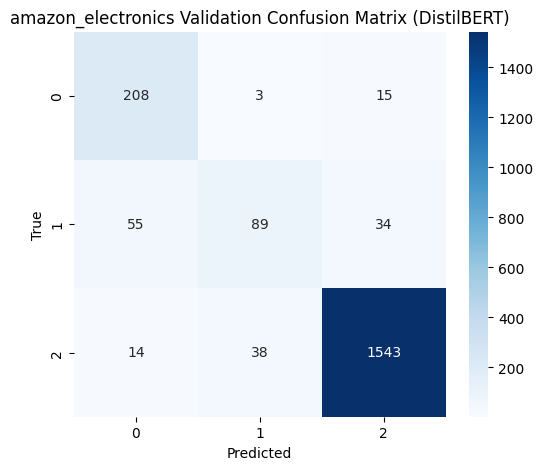

In [23]:
# Set model to evaluation mode (disables dropout and gradient updates)
model.to(device)
model.eval()
val_preds, val_labels = [], []   # Lists to store predictions and true labels

# Disable gradient computation for faster inference and lower memory usage
with torch.no_grad():
    for batch in val_loader:

        # Move batch data to the selected device (GPU/CPU)
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels         = batch['labels'].to(device)

        # Forward pass (no labels provided → no loss returned)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits                    # Raw output scores

        # Convert logits to predicted class indices
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        # Store predictions and true labels
        val_preds.extend(preds)
        val_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics for the Amazon Electronics validation set
val_acc = accuracy_score(val_labels, val_preds)
val_f1  = f1_score(val_labels, val_preds, average='weighted')

# Display results
print("\n=== amazon_electronics Validation Set Evaluation ===")
print(f"Accuracy: {val_acc:.3f}")
print(f"Weighted F1: {val_f1:.3f}")
print("\nClassification Report:")
print(classification_report(val_labels, val_preds))

cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("amazon_electronics Validation Confusion Matrix (DistilBERT)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

**Insights:**
DistilBERT performs strongly overall with an accuracy of 0.81, showing better balance than your BiLSTM. Class 2 (positive) remains the easiest to classify, but unlike earlier models, DistilBERT improves recall for class 0 (negative) from 0.16 (BiLSTM) to 0.65 and raises class 1 (neutral) precision and recall as well. The confusion matrix shows fewer misclassifications into the positive class, meaning DistilBERT is less biased toward the majority class. Overall, the model captures sentiment cues more effectively across all classes, demonstrating stronger generalization in-domain.

## Cross-domain Evaluation (sephora_skincare)


=== sephora_skincare Cross-Domain Evaluation ===
Accuracy: 0.776
Weighted F1: 0.794

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.66      0.57       540
           1       0.20      0.29      0.23       415
           2       0.92      0.84      0.88      4033

    accuracy                           0.78      4988
   macro avg       0.54      0.60      0.56      4988
weighted avg       0.82      0.78      0.79      4988



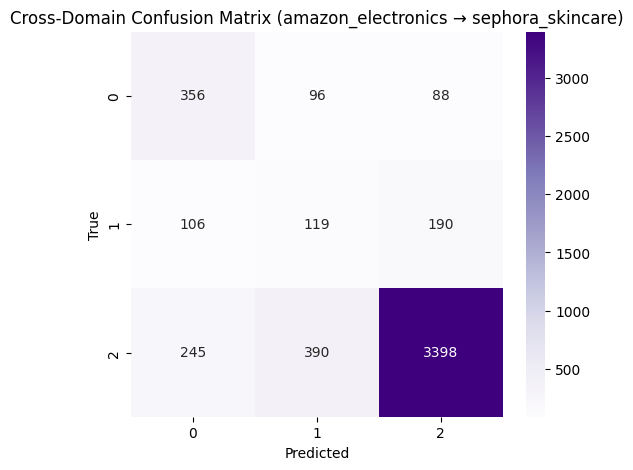

In [24]:
# Prepare DataLoader for sephora_skincare test
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        test_preds.extend(preds)
        test_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(test_labels, test_preds)
test_f1  = f1_score(test_labels, test_preds, average='weighted')

print("\n=== sephora_skincare Cross-Domain Evaluation ===")
print(f"Accuracy: {test_acc:.3f}")
print(f"Weighted F1: {test_f1:.3f}")
print("\nClassification Report:")
print(classification_report(test_labels, test_preds))

cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Cross-Domain Confusion Matrix (amazon_electronics → sephora_skincare)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

**Insights:**

DistilBERT shows stronger cross-domain robustness than the BiLSTM, achieving 0.78 accuracy and a high 0.79 weighted F1-score on Sephora skincare reviews. Unlike earlier models, DistilBERT correctly identifies a substantial portion of negative (0) and neutral (1) reviews, reducing the majority-class bias seen before. However, the confusion matrix still shows a tendency to overpredict class 2 (positive), especially for mixed or vague reviews. Overall, DistilBERT retains much of its in-domain performance, indicating better generalization across domains, though class imbalance effects remain noticeable.

## Comparison performance for cross domain shift

In [29]:
amazon_electronics_acc = accuracy_score(val_labels, val_preds)
amazon_electronics_precision = precision_score(val_labels, val_preds, average='weighted')
amazon_electronics_recall = recall_score(val_labels, val_preds, average='weighted')
amazon_electronics_f1 = f1_score(val_labels, val_preds, average='weighted')

sephora_acc = accuracy_score(test_labels, test_preds)
sephora_precision = precision_score(test_labels, test_preds, average='weighted')
sephora_recall = recall_score(test_labels, test_preds, average='weighted')
sephora_f1 = f1_score(test_labels, test_preds, average='weighted')


# DistilBERT results
distilbert_results = pd.DataFrame({
    'Model': ['DistilBERT', 'DistilBERT'],
    'Dataset': ['amazon_electronics (In-domain)', 'sephora_skincare (Cross-domain)'],
     'Accuracy': [amazon_electronics_acc, sephora_acc],
    'Precision': [amazon_electronics_precision, sephora_precision],
    'Recall': [amazon_electronics_recall, sephora_recall],
    'F1-score': [amazon_electronics_f1, sephora_f1]
})


distilbert_results.to_csv("distilbert_results.csv", index=False)

print("\n=== Cross domain Comparison for  DistilBERT===")
distilbert_results



=== Cross domain Comparison for  DistilBERT===


,Model,Dataset,Accuracy,Precision,Recall,F1-score
0,DistilBERT,amazon_electronics (In-domain),0.920460,0.919196,0.920460,0.917575
1,DistilBERT,sephora_skincare (Cross-domain),0.776464,0.818272,0.776464,0.794009


**Insights:**
DistilBERT shows strong in-domain performance on Amazon reviews (92.04% accuracy, F1 = 0.9176), and although performance drops when applied to Sephora (cross-domain), it remains comparatively robust with 77.65% accuracy and an F1 of 0.7940. This indicates that DistilBERT transfers sentiment knowledge reasonably well even when product context and vocabulary change. The moderate performance gap reflects domain shift, yet the model’s relatively high F1-score suggests it still captures sentiment cues beyond domain-specific wording, offering better generalization than traditional techniques.